# Batch downloading thumbnail images from the BDGP FTP server
> Python code to select and copy images from the BDGP FTP server and
store them on gDrive.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Thomas Sandmann
- categories: [BDGP, python, colab, gDrive]

In [1]:
from functools import lru_cache
import os
import random
import urllib
import pandas as pd
from pathlib import Path
from google.colab import drive
from PIL import Image

In [2]:
# mount gDrive for persistent storage as outlined here:
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH
drive.mount('/content/drive', force_remount=True)
# and create a subdirectory to store the files for this project
!mkdir -p /content/drive/My\ Drive/colab_data/bdgp
# then make it the working directory
%cd /content/drive/My\ Drive/colab_data/bdgp

Mounted at /content/drive
/content/drive/My Drive/colab_data/bdgp


## Batch downloading images

To download a specific subset of *in situ* hybridization images from the BDGP FTP server, I first download the image metadata file (in CSV format)
and store it in this project's directory on gDrive.

To avoid re-downloading the same images, I set the `download_images` variable here:

In [3]:
download_images = False

In [4]:

@lru_cache(maxsize=None)
def retrieve_image_metadata(path=None):
  "Load BDGP metadata from a local (cached) or remote CSV file"
  server = "https://insitu.fruitfly.org/"
  if path and os.path.isfile(path):
    print(f"Reading image metadata from cached file {path}.") 
    images = pd.read_csv(path)
  else:
    image_metadata = server + "insitu-mysql-dump/insitu_images.csv.gz"
    print(f"Downloading image metadata from {image_metadata}.") 

    images = pd.read_csv(image_metadata, header=None, compression="gzip",
                         encoding="latin1", index_col=False,
                         names=['id','symbol', 'annotation_symbol',
                              'FBgn', 'cDNA_clone', 'path', 'stage', 'pov',
                               'comment', 'resolution'])
    if path:
      print(f"Caching metadata as {path}.")
      images.to_csv(path)
  images["stage"] = images["stage"].astype('category')
  images = images[images.path.notna()]  
  return images

def retrieve_images(paths, outdir, ftp_root='ftp://ftp.fruitfly.org/pub/'
                     'insitu_image_storage/thumbnails/'):
  "Copy an impages from the BDGP FTP server to the output directory"
  outdir = Path(outdir)
  os.makedirs(outdir, exist_ok=True)
  for path in paths:
    try:
      response = urllib.request.urlopen(ftp_root + path).read()
      path = Path(path).name
      with open(outdir / path, 'wb') as handler:
        handler.write(response)  
    except urllib.error.HTTPError as e:
      print(f'{path.name}: HTTPError: {e.code}')
      next()
    except:
      print(path)
      next()

    

With the two functions to 1) load the metadata DataFrame and 2) copy images from the BDGP's FTP server to my gDrive folder in place, I am ready to retrieve a small subset of the available dataset: I random select 200 lateral thumbnails from both 1) *early* and 2) *late* stage embryos. These images can serve as a first step for my image analysis journey and I copy them to my project's gDrive folder.

In [5]:
metadata = retrieve_image_metadata('insitu_images.csv.gz')
stage1 = metadata \
  .query('stage == 1 and resolution == "low" and pov == "lateral"') \
  .sample(200, random_state=123) \
  .path \
  .tolist()
stage6 = metadata \
  .query('stage == 6 and resolution == "low" and pov == "lateral"') \
  .sample(200, random_state=123) \
  .path \
  .tolist()

Reading image metadata from cached file insitu_images.csv.gz.


In [6]:
if download_images:
  retrieve_images(stage1, outdir="thumbnails/stage1")
  retrieve_images(stage6, outdir="thumbnails/stage6")

Let's take a quick peek at a random image from each class, e.g. one early-stage and one late-stage embryo:

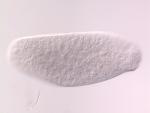

In [7]:
random.seed(123)
Image.open(Path("thumbnails/stage1") / Path(random.choice(stage1)).name)

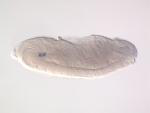

In [8]:
random.seed(123)
Image.open(Path("thumbnails/stage6") / Path(random.choice(stage6)).name)